In [1]:
###
# network and ngram analysis for the Gowers_7 session 
# home of the Pivot
###

In [2]:
#need to store the data in a dataframe
import pandas as pd 
import pandasql
import networkx as nx
import matplotlib.pyplot as plt

from pandasql import sqldf
from datetime import datetime

In [3]:
### reading csv into dataframe
df = pd.read_csv('/Users/jennaolsen/Library/CloudStorage/Dropbox/PhD/Polymath1 Project/Gowers_7.csv')
# note, removed a single post which occured over two years after the previous
# post details: C12981,Gowers_7,11/4/11 0:35,Nicholas Locascio,coalescence,alternate approaches
df['updated_timestamp'] = pd.to_datetime(df['updated_timestamp'])
print(df)

   blog_counter post_code   updated_timestamp     post_author  \
0         C1913  Gowers_7 2009-02-06 15:14:00  Ryan O'Donnell   
1         C1915  Gowers_7 2009-02-06 17:10:00  Ryan O'Donnell   
2         C1916  Gowers_7 2009-02-06 17:11:00      Jason Dyer   
3         C1918  Gowers_7 2009-02-06 17:13:00          gowers   
4         C1926  Gowers_7 2009-02-06 19:25:00  Ryan O'Donnell   
..          ...       ...                 ...             ...   
65        C2003  Gowers_7 2009-02-08 19:25:00           Boris   
66        C2004  Gowers_7 2009-02-08 19:30:00           Boris   
67        C2007  Gowers_7 2009-02-08 20:05:00           Boris   
68        C2023  Gowers_7 2009-02-09 02:36:00     Terence Tao   
69        C2047  Gowers_7 2009-02-09 10:49:00          gowers   

          move_category            move_name  
0   check understanding     asking questions  
1   check understanding  answer or statement  
2   check understanding     asking questions  
3   check understanding  answer

In [4]:
# basic statistics for the post of interest
query = """ 
        SELECT post_code, count(*) as records
            ,count(distinct(post_author)) as authors_intereacting
            ,min(updated_timestamp) as first_interaction
            ,max(updated_timestamp) as last_interaction
        from df
            group by post_code
                having count(*) > 1
        order by records desc, authors_intereacting
            ;
        """

result = sqldf(query)
result

,post_code,records,authors_intereacting,first_interaction,last_interaction
0,Gowers_7,70,7,2009-02-06 09:03:00.000000,2009-02-09 11:07:00.000000


In [5]:
# data frame with the prev timestamp for each post
query = """ 
        with 
            r as (
                select distinct post_code as pa
                from result
                where records > 1
                )
            ,lagged_timestamp as (    
                SELECT distinct df.post_code, df.blog_counter, df.post_author, df.updated_timestamp
                    ,lag(df.updated_timestamp) over 
                        (partition by df.post_code order by df.updated_timestamp) as prev_timestamp
                from df
                join r on df.post_code = r.pa
            )
            select *
            from lagged_timestamp lt
            where prev_timestamp != 'None'
            ;
        """

result_s = sqldf(query)
# change data type
result_s['updated_timestamp'] = pd.to_datetime(result_s['updated_timestamp'])
result_s['prev_timestamp'] = pd.to_datetime(result_s['prev_timestamp'])
# calculate time twixt
result_s['minutes_between'] = (result_s['updated_timestamp'] - result_s['prev_timestamp']).dt.total_seconds()/60
result_s

,post_code,blog_counter,post_author,updated_timestamp,prev_timestamp,minutes_between
0,Gowers_7,C1904,gowers,2009-02-06 11:16:00,2009-02-06 09:03:00,133.0
1,Gowers_7,C1905,gowers,2009-02-06 11:29:00,2009-02-06 11:16:00,13.0
2,Gowers_7,C1906,gowers,2009-02-06 11:45:00,2009-02-06 11:29:00,16.0
3,Gowers_7,C1907,gowers,2009-02-06 12:26:00,2009-02-06 11:45:00,41.0
4,Gowers_7,C1908,gowers,2009-02-06 12:36:00,2009-02-06 12:26:00,10.0
...,...,...,...,...,...,...
64,Gowers_7,C2018,Terence Tao,2009-02-09 00:03:00,2009-02-08 21:18:00,165.0
65,Gowers_7,C2020,gowers,2009-02-09 00:24:00,2009-02-09 00:03:00,21.0
66,Gowers_7,C2023,Terence Tao,2009-02-09 02:36:00,2009-02-09 00:24:00,132.0
67,Gowers_7,C2047,gowers,2009-02-09 10:49:00,2009-02-09 02:36:00,493.0


In [6]:
# pulling posts with at least one session
query = """ 
        with 
            r as (
                select distinct post_code as pa 
                from result_s 
                where minutes_between <= 30
                )
            ,session_incrementer as (    
                select lt.*
                    ,case when minutes_between > 30 then 1 else 0 end as session_incrementer
                from result_s lt
                join r on lt.post_code = r.pa
            )
            
            select si.*
                ,sum(session_incrementer) over (partition by post_code order by updated_timestamp) as session_num
            from session_incrementer si
            
            ;
        """

result_sessions = sqldf(query)
result_sessions

,post_code,blog_counter,post_author,updated_timestamp,prev_timestamp,minutes_between,session_incrementer,session_num
0,Gowers_7,C1904,gowers,2009-02-06 11:16:00.000000,2009-02-06 09:03:00.000000,133.0,1,1
1,Gowers_7,C1905,gowers,2009-02-06 11:29:00.000000,2009-02-06 11:16:00.000000,13.0,0,1
2,Gowers_7,C1906,gowers,2009-02-06 11:45:00.000000,2009-02-06 11:29:00.000000,16.0,0,1
3,Gowers_7,C1907,gowers,2009-02-06 12:26:00.000000,2009-02-06 11:45:00.000000,41.0,1,2
4,Gowers_7,C1908,gowers,2009-02-06 12:36:00.000000,2009-02-06 12:26:00.000000,10.0,0,2
...,...,...,...,...,...,...,...,...
64,Gowers_7,C2018,Terence Tao,2009-02-09 00:03:00.000000,2009-02-08 21:18:00.000000,165.0,1,27
65,Gowers_7,C2020,gowers,2009-02-09 00:24:00.000000,2009-02-09 00:03:00.000000,21.0,0,27
66,Gowers_7,C2023,Terence Tao,2009-02-09 02:36:00.000000,2009-02-09 00:24:00.000000,132.0,1,28
67,Gowers_7,C2047,gowers,2009-02-09 10:49:00.000000,2009-02-09 02:36:00.000000,493.0,1,29


In [7]:
query = """ 
            select post_code, session_num
                ,count(distinct(post_code)) as posts_in_session
                ,min(updated_timestamp) as start_of_session
                ,max(updated_timestamp) as end_of_session
                ,count(*) as actions_in_session
                ,avg(minutes_between) as avg_minutes_between_actions
                ,min(minutes_between) as min_minutes_between_actions
                ,max(minutes_between) as max_minutes_between_actions
            from result_sessions si
            group by post_code, session_num
            ;
        """

player_sessions = sqldf(query)
# change data type for dates
player_sessions['end_of_session'] = pd.to_datetime(player_sessions['end_of_session'])
player_sessions['start_of_session'] = pd.to_datetime(player_sessions['start_of_session'])
# calculate time twixt
player_sessions['session_length_minutes'] = (player_sessions['end_of_session'] - player_sessions['start_of_session']).dt.total_seconds()/60
player_sessions

,post_code,session_num,posts_in_session,start_of_session,end_of_session,actions_in_session,avg_minutes_between_actions,min_minutes_between_actions,max_minutes_between_actions,session_length_minutes
0,Gowers_7,1,1,2009-02-06 11:16:00,2009-02-06 11:45:00,3,54.000000,13.0,133.0,29.0
1,Gowers_7,2,1,2009-02-06 12:26:00,2009-02-06 13:59:00,6,22.333333,10.0,41.0,93.0
2,Gowers_7,3,1,2009-02-06 15:14:00,2009-02-06 15:14:00,1,75.000000,75.0,75.0,0.0
3,Gowers_7,4,1,2009-02-06 16:49:00,2009-02-06 18:33:00,9,22.111111,1.0,95.0,104.0
4,Gowers_7,5,1,2009-02-06 19:15:00,2009-02-06 19:37:00,6,10.666667,1.0,42.0,22.0
5,Gowers_7,6,1,2009-02-06 20:08:00,2009-02-06 20:30:00,2,26.500000,22.0,31.0,22.0
6,Gowers_7,7,1,2009-02-06 21:29:00,2009-02-06 21:53:00,4,20.750000,6.0,59.0,24.0
7,Gowers_7,8,1,2009-02-06 23:11:00,2009-02-06 23:11:00,1,78.000000,78.0,78.0,0.0
8,Gowers_7,9,1,2009-02-06 23:52:00,2009-02-06 23:52:00,1,41.000000,41.0,41.0,0.0
9,Gowers_7,10,1,2009-02-07 01:48:00,2009-02-07 01:48:00,1,116.000000,116.0,116.0,0.0


In [8]:
# moves happening in the session
query = """ 
           with d as (
               select ps.session_num
                   ,df.*
               from df
               join player_sessions ps 
                   on df.post_code = ps.post_code 
                   and df.updated_timestamp >= ps.start_of_session
                   and df.updated_timestamp <= ps.end_of_session
            )
            , for_rown as (
                select post_code || '_' || session_num as session_key, session_num, move_category, move_name, updated_timestamp
                from d
            )
            select row_number() over (partition by session_key order by updated_timestamp) as rown
                ,session_key, move_category, move_name
                ,move_category || '-' || coalesce(move_name,'None') as move, updated_timestamp
            from for_rown
            order by session_num
        """

df_ps = sqldf(query)
df_ps

,rown,session_key,move_category,move_name,move,updated_timestamp
0,1,Gowers_7_1,working the problem,thread management,working the problem-thread management,2009-02-06 11:16:00.000000
1,2,Gowers_7_1,working the problem,None,working the problem-None,2009-02-06 11:29:00.000000
2,3,Gowers_7_1,working the problem,monologue continued,working the problem-monologue continued,2009-02-06 11:45:00.000000
3,1,Gowers_7_2,working the problem,monologue continued,working the problem-monologue continued,2009-02-06 12:26:00.000000
4,2,Gowers_7_2,working the problem,monologue continued,working the problem-monologue continued,2009-02-06 12:36:00.000000
...,...,...,...,...,...,...
64,1,Gowers_7_27,coalescence,summarize,coalescence-summarize,2009-02-09 00:03:00.000000
65,2,Gowers_7_27,coalescence,cross-thread references,coalescence-cross-thread references,2009-02-09 00:24:00.000000
66,1,Gowers_7_28,working the problem,thread management,working the problem-thread management,2009-02-09 02:36:00.000000
67,1,Gowers_7_29,working the problem,thread management,working the problem-thread management,2009-02-09 10:49:00.000000


In [9]:
# chronological sequence of moves
df_ps.pivot(index='session_key', columns='rown', values='move')

rown,1,2,3,4,5,6,7,8,9
session_key,,,,,,,,,
Gowers_7_1,working the problem-thread management,working the problem-None,working the problem-monologue continued,NaN,NaN,NaN,NaN,NaN,NaN
Gowers_7_10,working the problem-show your work,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gowers_7_11,working the problem-show your work,check understanding-asking questions,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gowers_7_12,meta-thought process,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gowers_7_13,meta-thought process,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gowers_7_14,meta-thought process,working the problem-monologue continued,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gowers_7_15,working the problem-correction,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gowers_7_16,coalescence-cross-thread references,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gowers_7_17,check understanding-asking questions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# add nodes for different potential moves 
query = """ 
            select distinct move from df_ps
        """

moves = sqldf(query)

# Create an empty list
li_moves = []

# Iterate over each row
for index, rows in moves.iterrows():
    #add move to the list
    li_moves.append(rows.move)

{('working the problem-thread management',
  'check understanding-answer or statement'): Text(-0.1674359343351231, -0.27684713153294893, '0.4629629629629629'),
 ('working the problem-thread management',
  'working the problem-None'): Text(-0.1816292433688332, -0.3583789917384409, '0.4629629629629629'),
 ('working the problem-thread management',
  'working the problem-monologue continued'): Text(-0.2477489595259611, -0.44661046479505057, '0.4629629629629629'),
 ('working the problem-None',
  'check understanding-answer or statement'): Text(-0.14860175378051854, -0.09840330209836659, '3.2407407407407405'),
 ('working the problem-None',
  'check understanding-asking questions'): Text(-0.05929376653281964, -0.1164679893997314, '1.8518518518518516'),
 ('working the problem-None',
  'meta-interesting'): Text(-0.03992892558973978, -0.18649584527951044, '1.3888888888888888'),
 ('working the problem-None',
  'meta-thought process'): Text(-0.1292699099875676, -0.14130585670990767, '2.31481481481

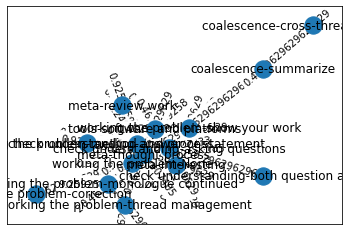

In [11]:
# using the moves

# use the session key for grouping and the updated timestamp for avoiding self-joins
query = """ 
        with moves as (
            select df_ps1.move, df_ps2.move as move2
            from df_ps df_ps1
                join df_ps df_ps2 on df_ps1.session_key = df_ps2.session_key
                and df_ps1.updated_timestamp != df_ps2.updated_timestamp
                )
        select move, move2, count(*) as records
        from moves
        group by move, move2
        """

df_moves = sqldf(query)
#use percent of total so I can compare each thread (or other grouping) to others or to the project as a whole
df_moves['percent'] = (df_moves['records'] / df_moves['records'].sum()) * 100

G = nx.Graph()

#li_moves has the nodes
G.add_nodes_from(li_moves)

# Iterate over each row adding the edge and weight
for index, rows in df_moves.iterrows():
    G.add_edge(rows.move, rows.move2, weight=rows.percent)
    
pos=nx.spring_layout(G) # pos = nx.nx_agraph.graphviz_layout(G)
nx.draw_networkx(G,pos)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

In [17]:
# add nodes for different potential moves 
query = """ 
            select distinct move_category from df_ps
        """

move_cats = sqldf(query)

# Create an empty list
li_move_cats = []

# Iterate over each row
for index, rows in move_cats.iterrows():
    #add move to the list
    li_move_cats.append(rows.move_category)
    
print(li_move_cats)

['working the problem', 'check understanding', 'meta', 'tools', 'coalescence']


{('working the problem',
  'check understanding'): Text(0.020670503913808667, 0.22627362303015003, '0.4629629629629629'),
 ('working the problem',
  'coalescence'): Text(-0.3476872164584107, -0.5707290417380407, '0.4629629629629629'),
 ('working the problem',
  'meta'): Text(0.04485666620298131, 0.03221051763901192, '3.7037037037037033'),
 ('working the problem',
  'tools'): Text(0.1607243706132302, 0.10005777585475659, '0.4629629629629629'),
 ('working the problem',
  'working the problem'): Text(-0.08095711715226038, -0.14145808347608146, '1.8518518518518516'),
 ('check understanding',
  'check understanding'): Text(0.12229812497987771, 0.5940053295363815, '2.7777777777777777'),
 ('check understanding',
  'meta'): Text(0.14648428726905036, 0.3999422241452434, '3.2407407407407405'),
 ('check understanding',
  'tools'): Text(0.26235199167929923, 0.46778948236098805, '2.7777777777777777'),
 ('meta',
  'meta'): Text(0.170670449558223, 0.2058791187541053, '0.9259259259259258'),
 ('meta',


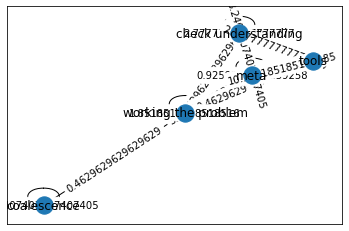

In [13]:
# using just the move categories

# use the session key for grouping and the updated timestamp for avoiding self-joins
query = """ 
        with cats as (
            select df_ps1.move_category, df_ps2.move_category as move_category2
            from df_ps df_ps1
                join df_ps df_ps2 on df_ps1.session_key = df_ps2.session_key
                and df_ps1.updated_timestamp != df_ps2.updated_timestamp
                )
        select move_category, move_category2, count(*) as records
        from cats
        group by move_category, move_category2
        """

df_m = sqldf(query)
#use percent of total so I can compare each thread (or other grouping) to others or to the project as a whole
df_m['percent'] = (df_moves['records'] / df_moves['records'].sum()) * 100
df_m

Gcat = nx.Graph()

#li_move_cats has the nodes
Gcat.add_nodes_from(li_move_cats)

# Iterate over each row adding the edge and weight
for index, rows in df_m.iterrows():
    Gcat.add_edge(rows.move_category, rows.move_category2, weight=rows.percent)
    
pos=nx.spring_layout(Gcat) 
nx.draw_networkx(Gcat,pos)
labels = nx.get_edge_attributes(Gcat,'weight')
nx.draw_networkx_edge_labels(Gcat,pos,edge_labels=labels)

{('working the problem',
  'check understanding'): Text(-0.07137895298366824, -0.18300412968681687, '0.4629629629629629'),
 ('working the problem',
  'coalescence'): Text(-0.0439541155777818, 0.5683105344547158, '0.4629629629629629'),
 ('working the problem',
  'meta'): Text(0.01874177098316783, -0.04197535014540228, '3.7037037037037033'),
 ('working the problem',
  'tools'): Text(0.0832593570935837, -0.13839945125834932, '0.4629629629629629'),
 ('working the problem',
  'working the problem'): Text(-0.008887960323132337, 0.13662106890943154, '1.8518518518518516'),
 ('check understanding',
  'check understanding'): Text(-0.13386994564420415, -0.5026293282830653, '2.7777777777777777'),
 ('check understanding',
  'meta'): Text(-0.043749221677368076, -0.3616005487416507, '3.2407407407407405'),
 ('check understanding',
  'tools'): Text(0.02076836443304779, -0.45802464985459773, '2.7777777777777777'),
 ('meta',
  'meta'): Text(0.046371502289468, -0.2205717692002361, '0.9259259259259258'),
 

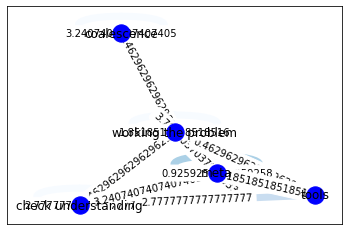

In [16]:
edges,weights = zip(*nx.get_edge_attributes(Gcat,'weight').items())

pos = nx.spring_layout(Gcat)
nx.draw_networkx(Gcat, pos, node_color='b', edgelist=edges, edge_color=weights, width=7.0, edge_cmap=plt.cm.Blues)
nx.draw_networkx_edge_labels(Gcat,pos,edge_labels=labels)
# plt.savefig('edges.png')